In [1]:
# Standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Custom modules
from jpm_logger import JpmLogger
from jpm_number_printing import latex_float

__author__ = 'James Paul Mason'
__contact__ = 'jmason86@gmail.com'


def determine_dimming_slope(light_curve_df, 
                            earliest_allowed_time=None, latest_allowed_time=None, smooth_points=0, 
                            plot_path_filename=None, verbose=False):
    """Find the slope of dimming in a light curve, if any.

    Inputs:
        light_curve_df [pd DataFrame]:    A pandas DataFrame with a DatetimeIndex and a column for irradiance.
        
    Optional Inputs:
        earliest_allowed_time [metatime]: The function won't return a depth determined any earlier than this.
                                          It is recommended that this be the peak time of the flare.
                                          Default is None, meaning the beginning of the light_curve_df.
        latest_allowed_time [metatime]:   The function won't return a depth determined any later than this.
                                          It is recommended that this be the identified time of dimming depth.
                                          Default is None, meaning the end of the light_curve_df.
        smooth_points [integer]:          Used to apply a rolling mean with the number of points (indices) specified.
                                          Default is 0, meaning no smoothing will be performed.
        plot_path_filename [str]:         Set to a path and filename in order to save the summary plot to disk.
                                          Default is None, meaning the plot will not be saved to disk.
        verbose [bool]:                   Set to log the processing messages to disk and console. Default is False.

    Outputs:
        slope_min [float]: The minimum slope of dimming in percent/second terms. 
        slope_max [float]: The maximum slope of dimming in percent/second terms. 
        slope_mean [float]: The mean slope of dimming in percent/second terms. 
        
    Optional Outputs:
        None

    Example:
        slope_min, slope_max, slope_mean = determine_dimming_slope(light_curve_df,
                                                                   plot_path_filename='./determine_dimming_slope_summary.png',
                                                                   verbose=True)
    """
    return 1

In [2]:
# prototype only: set up example inputs
%matplotlib inline
plt.style.use('jpm-light')
earliest_allowed_time = pd.Timestamp('2012-04-15 17:52:20.0')  # The identified peak time for this event
latest_allowed_time = pd.Timestamp('2012-04-15 18:43:19.0')  # The identified depth time for this event
smooth_points = 0
plot_path_filename = './determine_dimming_slope_summary.png'
verbose = True

light_curve_df = pd.read_hdf('/Users/jmason86/Dropbox/Research/Postdoc_NASA/Analysis/Coronal Dimming Analysis/Example Fit Dimming Light Curve.hdf',
                             'light_curve_df')
light_curve_df['irradiance'] = light_curve_df['irradiance'] - 1  # Just need something under 0%
light_curve_df.head()

,irradiance,uncertainty
2012-04-15 17:43:20,-0.851300,0.160099
2012-04-15 17:44:19,-0.700667,0.160099
2012-04-15 17:45:18,-0.559752,0.160099
2012-04-15 17:46:17,-0.428509,0.160099
2012-04-15 17:47:16,-0.306866,0.160099


In [3]:
# Prepare the logger for verbose
if verbose:
    # TODO: Update the path
    logger = JpmLogger(filename='determine_dimming_slope_log', path='/Users/jmason86/Desktop/')
    logger.info("Running on event with light curve start time of {0}.".format(light_curve_df.index[0]))

2018-01-04 13:17:46,175 [INFO ] [<module>] Running on event with light curve start time of 2012-04-15 17:43:20.


In [4]:
# If no earliest_allowed_time set, then set it to beginning of light_curve_df
if not earliest_allowed_time:
    earliest_allowed_time = light_curve_df.index[0]
    logger.info("No earliest allowed time provided. Setting to beginning of light curve: {0}".format(earliest_allowed_time))
    
# If no latest_allowed_time set, then set it to end of light_curve_df
if not latest_allowed_time:
    latest_allowed_time = light_curve_df.index[-1]
    logger.info("No latest allowed time provided. Setting to end of light curve: {0}".format(latest_allowed_time))

In [5]:
# Optionally smooth the light curve with a rolling mean 
if smooth_points:
    light_curve_df['irradiance'] = light_curve_df.rolling(smooth_points, center=True).mean()
    if verbose:
        logger.info('Applied {0} point smooth.'.format(smooth_points))
        
first_non_nan = light_curve_df['irradiance'].first_valid_index()
nan_indices = np.isnan(light_curve_df['irradiance'])
light_curve_df['irradiance'][nan_indices] = light_curve_df['irradiance'][first_non_nan]

In [6]:
# Find the max in the allowed window
max_time = light_curve_df[earliest_allowed_time:latest_allowed_time]['irradiance'].idxmax()
max_irradiance = light_curve_df['irradiance'].loc[max_time]
if verbose:
    logger.info('Maximum in allowed window found with value of {0:.2f} at time {1}'.format(max_irradiance, max_time))

2018-01-04 13:17:46,204 [INFO ] [<module>] Maximum in allowed window found with value of 0.49 at time 2012-04-15 18:02:01


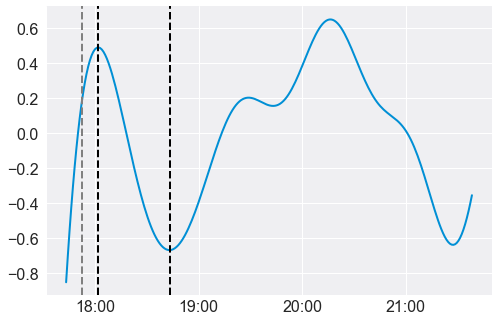

In [7]:
# prototype only: sanity check plot
light_curve_df['irradiance'].plot()
plt.axvline(x=earliest_allowed_time, linestyle='dashed', color='grey')
plt.axvline(x=latest_allowed_time, linestyle='dashed', color='black')
plt.axvline(x=max_time, linestyle='dashed', color='black');

In [8]:
# Compute the derivative in the time window of interest (inverting sign so that we describe "downward slope")
derivative = -light_curve_df[max_time:latest_allowed_time]['irradiance'].diff() / light_curve_df[max_time:latest_allowed_time].index.to_series().diff().dt.total_seconds()
if verbose:
    logger.info("Computed derivative of light curve within time window of interest.")

2018-01-04 13:17:46,419 [INFO ] [<module>] Computed derivative of light curve within time window of interest.


count    42.000000
mean      0.000467
std       0.000231
min       0.000015
25%       0.000288
50%       0.000520
75%       0.000678
max       0.000740
dtype: float64

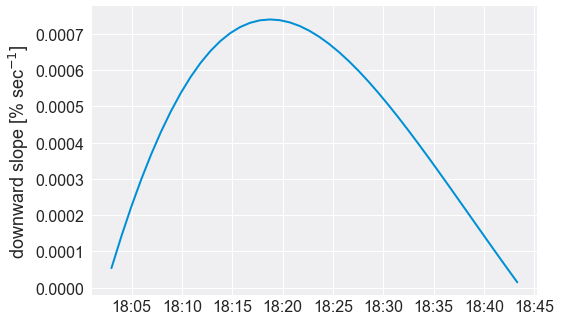

In [9]:
# prototype only: plot the derivative and get basic stats
derivative.plot()
plt.ylabel('downward slope [% sec$^{-1}$]');
derivative.describe()

In [10]:
# Get the min, max, and mean slope
slope_min = derivative.min()
slope_max = derivative.max()
slope_mean = derivative.mean()
slope_min_str = latex_float(slope_min)
slope_max_str = latex_float(slope_max)
slope_mean_str = latex_float(slope_mean)
if verbose:
    logger.info("Computed min ({0}), max ({1}), and mean ({2}) %/s slope.".format(slope_min_str, slope_max_str, slope_mean_str))

2018-01-04 13:17:46,841 [INFO ] [<module>] Computed min ($1.5 \times 10^{-5}$), max (0.00074), and mean (0.00047) %/s slope.


In [11]:
# Do a few sanity checks for the log
if verbose:
    if slope_min < 0:
        logger.warning("Minimum slope of {0} is unexpectedly < 0.".format(slope_min))
    if slope_max < 0: 
        logger.warning("Maximum slope of {0} is unexpectedly < 0.".format(slope_max))
    if slope_mean < 0: 
        logger.warning("Mean slope of {0} is unexpectedly < 0.".format(slope_mean))

2018-01-04 13:17:47,267 [INFO ] [<module>] Summary plot saved to ./determine_dimming_slope_summary.png


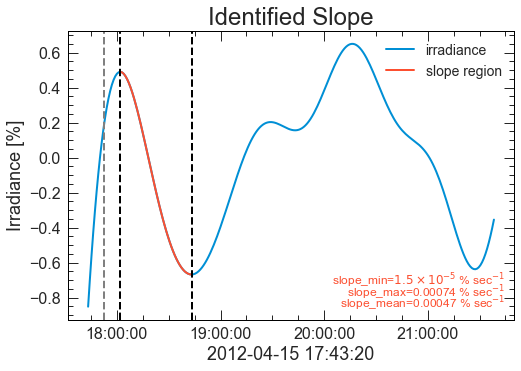

In [12]:
# Produce a summary plot
if plot_path_filename:
    plt.style.use('jpm-transparent-light')
    from matplotlib import dates
    
    p = plt.plot(light_curve_df['irradiance'])
    p = plt.plot(light_curve_df[max_time:latest_allowed_time]['irradiance'], label='slope region')
    ax = plt.gca()
    plt.axvline(x=earliest_allowed_time, linestyle='dashed', color='grey')
    plt.axvline(x=latest_allowed_time, linestyle='dashed', color='black')
    plt.axvline(x=max_time, linestyle='dashed', color='black');
    plt.title('Identified Slope')
    
    start_date = light_curve_df.index.values[0]
    start_date_string = pd.to_datetime(str(start_date))
    plt.xlabel(start_date_string.strftime('%Y-%m-%d %H:%M:%S'))
    fmtr = dates.DateFormatter("%H:%M:%S")
    ax.xaxis.set_major_formatter(fmtr)
    ax.xaxis.set_major_locator(dates.HourLocator())
    ax.xaxis.grid(b=True, which='minor')
    plt.ylabel('Irradiance [%]')
    
    ax.legend(loc='best')
    
    inverse_str = '$^{-1}$'
    plt.annotate('slope_min={0} % sec{1}'.format(slope_min_str, inverse_str), 
                 xy=(0.98, 0.12), xycoords='axes fraction', ha='right', 
                 size=12, color=p[0].get_color())
    plt.annotate('slope_max={0} % sec{1}'.format(slope_max_str, inverse_str), 
                 xy=(0.98, 0.08), xycoords='axes fraction', ha='right', 
                 size=12, color=p[0].get_color())
    plt.annotate('slope_mean={0} % sec{1}'.format(slope_mean_str, inverse_str), 
                 xy=(0.98, 0.04), xycoords='axes fraction', ha='right', 
                 size=12, color=p[0].get_color())

    plt.savefig(plot_path_filename)
    if verbose:
        logger.info("Summary plot saved to %s" % plot_path_filename)

In [13]:
# Return the slopes
return slope_min, slope_max, slope_mean

SyntaxError: 'return' outside function (<ipython-input-13-99d66d8a24c8>, line 2)